# Transfer Learning for Jet Tagging in Particle Physics: FCNN

This is the first accompanying notebook for our final project for the CSCI 2470: Deep Learning course. Here, we will present appropriate visualizations of our input data, build and train our models, and present appropriate visualizations of the outputs and results.

*Authors: Jade Ducharme, Egor Serebriakov, Aditya Singh, Anthony Wong*

## Background

Particle accelerator experiments at CERN produce massive amounts of data which non-ML analysis methods struggle to keep up with. A subset of these experiments concerns particle jets, which are streams of secondary particles created during the high energy collision of primary particles. Given a particle jet, we wish to rapidly identify the primary particles responsible for the jet in order to determine whether the experiment should be kept for further analysis.

Datastreams produced by these experiments contain "high-quality" information that would require massive amounts of memory to store. Our goal is then the following: can we train a "student" Neural Network to take in reduced, "low-quality" jet data and predict the primary particles that initiated the jet with the same accuracy as a "teacher" model trained on high-quality jet data? More simply, we will be performing a binary classification task to see whether our model can predict if the jet was initiated by a Top Quark ```label: 1``` or a "background" particle ```label: 0```.

Our code makes use of the [ATLAS Top Tagging Open Data Set](https://opendata.cern.ch/record/15013), a set of simulated jet events created by the ATLAS Collaboration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import seaborn as sns
from preprocess import *
from helper import *

sns.set_theme()
plt.style.use("seaborn-v0_8")

#### Input Data Visualization

As a very first step, let's load in our data to see what it looks like. Our data has three attributes: "jet", "constituents", and "high-level" information about each jet. The jet attribute stores information about the *entire* jet: for example, the jet's mass and momentum. Meanwhile, the constituent attribute stores information about *each individual* particle that compose the jet: each particle's mass and momentum, for example. Finally, the high-level attribute stores variables "chosen in two separate studies of high level quantity based top taggers carried out by the ATLAS collaboration" (from the [reference manual](https://gitlab.cern.ch/atlas/ATLAS-top-tagging-open-data/-/tree/master?ref_type=heads)). These high-level variables aren't super important, and we instead wish to train our model on the constituent attributes, which provide the most information to identify our jets.

In [2]:
jet_data, jet_labels, jet_weights, jet_features = get_data("./data/reduced_atlas_dataset.h5", attribute="jet")
cons_data, cons_labels, cons_weights, cons_features = get_data("./data/reduced_atlas_dataset.h5", attribute="constituents")

print("---------- Jet-level data ----------------")
print("Data shape [input_size, num_features]:", jet_data.shape)
print("Feature names:", [human_feature(f) for f in jet_features],"\n")

print("---------- Constituent-level data ----------------")
print("Data shape [input_size, num_features, num_constituents]:", cons_data.shape)
print("Feature names:", [human_feature(f) for f in cons_features])

---------- Jet-level data ----------------
Data shape [input_size, num_features]: (10000, 4)
Feature names: ['jet transverse momentum', 'jet pseudo-rapidity', 'jet azimuthal angle', 'jet mass'] 

---------- Constituent-level data ----------------
Data shape [input_size, num_features, num_constituents]: (10000, 4, 80)
Feature names: ['constituent transverse momentum', 'constituent pseudo-rapidity', 'constituent azimuthal angle', 'constituent energy']


As we can see, our features contain some important information about the jets: mass, energy, momentum, etc. We can visualize these features in a histogram:

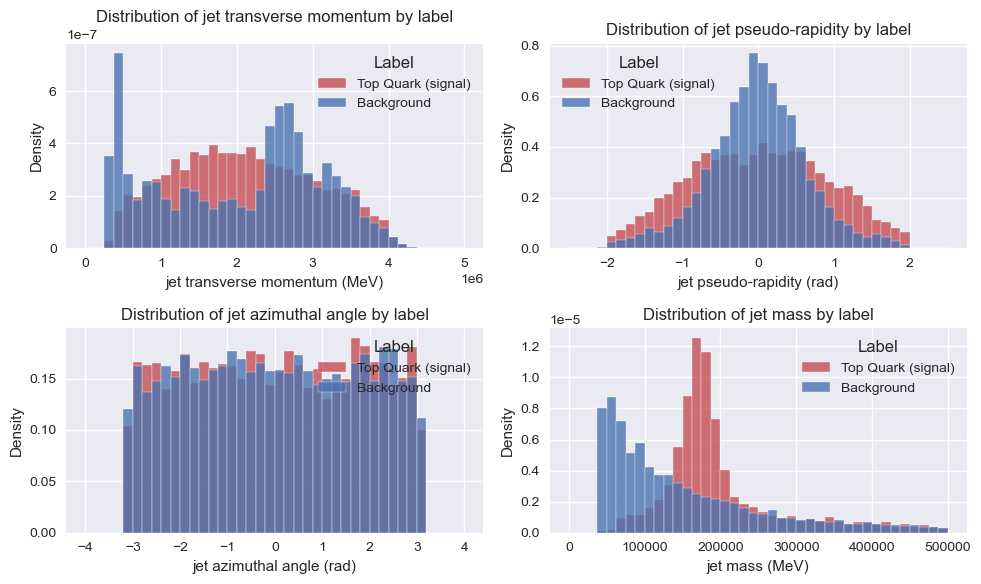

In [3]:
from visualize import *

plot_1D_distributions(jet_data, jet_labels, jet_features, nbins=40)

This histogram shows the distribution of jet mass, pseudo-rapidity, azimuthal angle, and energy by label. The human eye can clearly distinguish some patterns here! Now, let's see what the constituents' histograms look like:

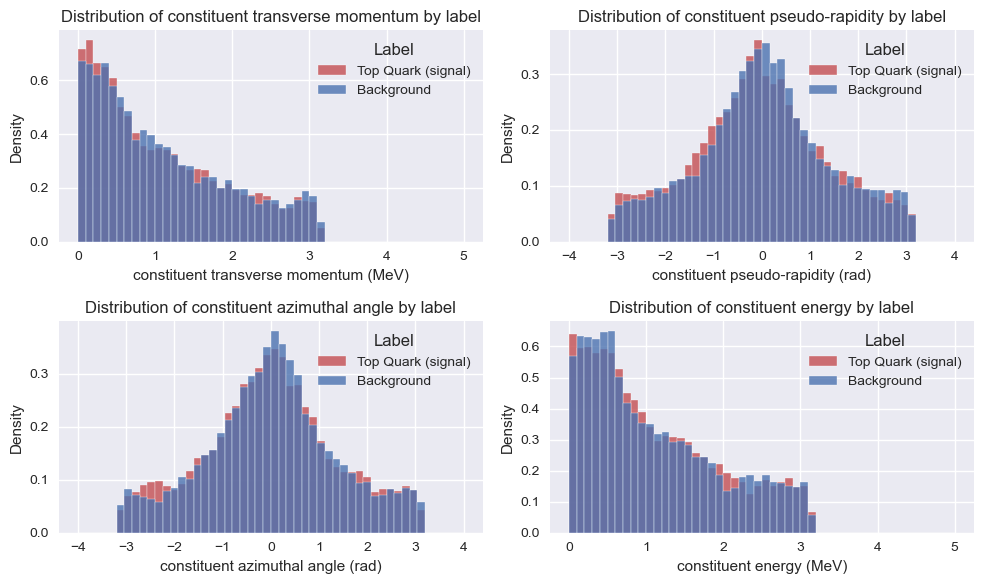

In [4]:
plot_1D_distributions(cons_data, cons_labels, cons_features, 50)

At the constituent level, it is much harder (even for the human eye) to distinguish the signal curve from the background curve. Let's hope a neural network can help us with this!

### Stage 1: Transfer Learning via FCNN

As a first step, we would like to ensure that we understand how to implement transfer learning. For this purpose, we will train a simple Teacher FCNN on the high quality ATLAS dataset. Next, we will downgrade this data via diffusion, transfer knowledge from the Teacher to the Student FCCN, and train this Student on the lower quality data. We will then compare their performances.

First, we will train the Teacher FCNN on constituent-level data.

In [5]:
from preprocess import preprocess_split
from model import TeacherFCNN, train_one_epoch, test

# model initialization
teacher_fcnn = TeacherFCNN(num_features=int(cons_data.shape[1]*cons_data.shape[2]))
optimizer = optim.Adam(teacher_fcnn.parameters(), lr=0.0001)
criterion = nn.BCELoss(reduction='none')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device,"\n")
teacher_fcnn.to(device)

# Data preparation
train_set, val_set, test_set = preprocess_split(cons_data, cons_labels, cons_weights, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=12, shuffle=True)
val_loader = DataLoader(val_set, batch_size=12, shuffle=True)
test_loader = DataLoader(test_set, batch_size=12, shuffle=True)

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

num_epochs = 50
for e in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch(teacher_fcnn, device, train_loader, optimizer, criterion)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test(teacher_fcnn, device, val_loader, criterion)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if e%5 == 0:
      print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t Train acc: {acc:.4f}\t"\
            + f"Val loss: {val_loss:.4f}\t Val acc: {val_acc:.4f}"
      )

Device: cpu 

Epoch 05	 Train loss: 0.6916	 Train acc: 0.5093	Val loss: 0.6861	 Val acc: 0.5067
Epoch 10	 Train loss: 0.6910	 Train acc: 0.5047	Val loss: 0.6879	 Val acc: 0.4927
Epoch 15	 Train loss: 0.6887	 Train acc: 0.5171	Val loss: 0.6872	 Val acc: 0.4960
Epoch 20	 Train loss: 0.6877	 Train acc: 0.5224	Val loss: 0.6897	 Val acc: 0.5027
Epoch 25	 Train loss: 0.6838	 Train acc: 0.5294	Val loss: 0.6914	 Val acc: 0.5020
Epoch 30	 Train loss: 0.6813	 Train acc: 0.5304	Val loss: 0.6942	 Val acc: 0.4933
Epoch 35	 Train loss: 0.6809	 Train acc: 0.5417	Val loss: 0.6946	 Val acc: 0.4967
Epoch 40	 Train loss: 0.6798	 Train acc: 0.5296	Val loss: 0.6941	 Val acc: 0.4987
Epoch 45	 Train loss: 0.6752	 Train acc: 0.5451	Val loss: 0.6991	 Val acc: 0.4953
Epoch 50	 Train loss: 0.6708	 Train acc: 0.5527	Val loss: 0.7010	 Val acc: 0.4907


In [6]:
# Testing on unseen data...

test_loss, test_acc = test(teacher_fcnn, device, test_loader, criterion)

print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

Final test loss: 0.6948	 Final test acc: 0.5207


#### Visualization

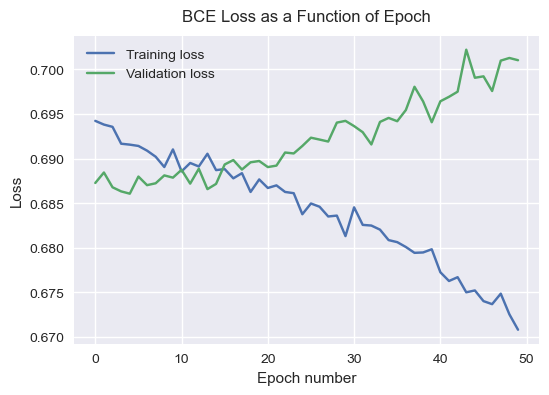

In [7]:
from visualize import plot_accuracy, plot_loss

plot_loss(loss_list, val_loss_list)

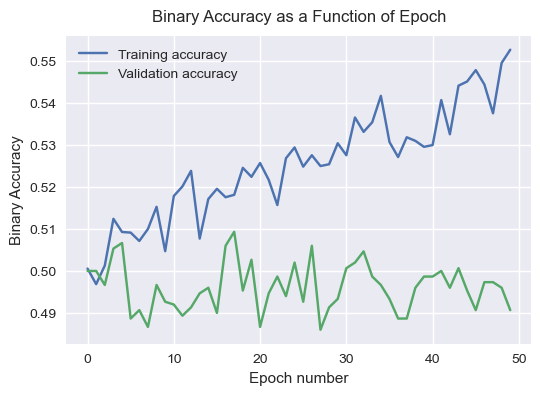

In [8]:
plot_accuracy(acc_list, val_acc_list)

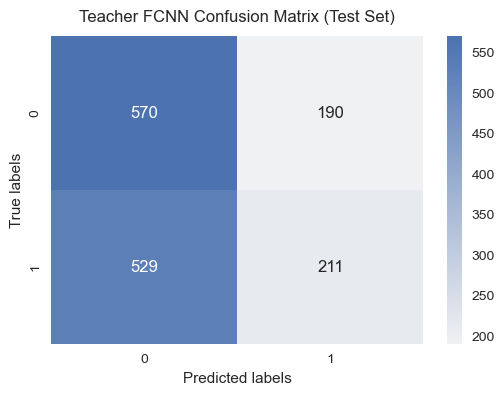

In [9]:
from visualize import plot_confusion_matrices

true = []
pred = []
for d, l, w in test_set:
    d = d.unsqueeze(0)  # at the batch dimension that the model expects
    true.append(int(l))
    pred.append(round(teacher_fcnn(d).item()))

plot_confusion_matrices(true, pred, "Teacher FCNN")

#### Degrade Data Quality

<!-- Loop over jet events -->
```
For one jet:

    Loop over constituents

        E --> G(mu=E, sigma=10% of E)
```

OR:

Randomly select $n<80$ constituents from each jet

In [10]:
# TODO!

Run the Teacher on the low-resolution data and show that the performance is reduced, then transfer learning

#### Transfer Learning to Student FCNN

In [11]:
# TODO!